## Compare our sustainability score to Newsweek's rankings

Objective
Once you obtain all the inference results, it could be helpful to analyze the correlation between the company scores
generated by your method and an external ranking

- Mark which companies we are using in our analysis.
- Find correlation between our score and the scores here.



Newsweek source: https://www.newsweek.com/rankings/americas-most-responsible-companies-2024  
IBD source: https://www.investors.com/news/esg-companies-list-top-100-esg-stocks-2022/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

### Read Newsweek & IBD rankings

In [2]:
nwdf = pd.read_csv('newsweek_responsibility_ranks.csv', index_col=None)
ibddf = pd.read_csv('ibd_ranks.csv', index_col=None)

In [3]:
nwdf.head()

,Rank,Company,HQ City,HQ State,Industry,Rank in Industry,Score Overall,Score Environmental Concerns,Score Social Concerns,Score Corporate Governance Concerns
0,1,Merck & Co,Rahway,New Jersey,Health Care & Life Sciences,1,91.98,91.41,84.61,100.00
1,2,Xylem,Washington,District of Columbia,Capital Goods,1,91.27,95.42,88.88,89.61
2,3,HP,Palo Alto,California,Technology Hardware,1,90.29,98.89,90.07,82.01
3,4,Cisco Systems,San Jose,California,Technology Hardware,2,90.03,98.60,84.15,87.46
4,5,Hewlett Packard Enterprise,Spring,Texas,Technology Hardware,3,88.37,94.55,81.48,89.16


In [4]:
ibddf.head()

,Rank,Company,Symbol,Industry,ESG Score,Comp Rtg,RS Rtg,EPS Rtg,SMR Rtg,3-Yr EPS Growth Rate,ROE,Last Qtr Sales % Chg,Last Qtr EPS % Chg,Div Yld
0,1,Worthington Industries,WOR,Metal-Processes/Fabrication,75.82,88,75,61,B,61,26,55,-32,2.4
1,2,J.B. Hunt Transport Services,JBHT,Transportation-Trucking,73.09,93,64,95,B,21,27,32,50,0.9
2,3,Verisk Analytics,VRSK,Commercial Services-Market Research,72.79,84,73,89,A,10,31,0,31,0.7
3,4,Texas Instruments,TXN,Electronics-Semiconductor Mfg,72.63,84,55,92,A,23,69,14,20,2.8
4,5,Apple,AAPL,Telecom-Consumer Products,72.36,89,75,84,A,34,147,2,-8,0.6


---

### Read companies we are analyzing

In [5]:
odf = pd.read_csv('../report_prediction/final_scores.csv', index_col=None)

- Manually add company names

In [166]:
# for c in nwdf['Company'][400:]:
#     print(c)

In [6]:
names = [
    'Tesla', 'United Parcel Service', 'Salesforce', 'Adobe', 'Pepsi', 'Schwab', 'Progressive', 'SAP', 'Bank of America', 'Procter & Gamble', 'BlackRock', 'Novo Nordisk', 'Comcast', 'Wells Fargo', 'Intuit', 'Berkshire Hills Bancorp', 'Oracle', 'Union Pacific', 'Danaher', 'Blackstone', 'Exxon Mobil', 'Abbvie',
    'Royal Bank of Canada', 'Amgen', 'S&P Global', 'Visa', 'AT&T', 'HDFC Bank', 'Walt Disney', 'JPMorgan Chase', 'Lowes', 'Micron', 'Goldman Sachs', 'Accenture', 'Toyota', 'Stryker', 'Walmart', 'Chevron', 'Honeywell', 'Lam Research', 'Intuitive', 'AstraZeneca', 'ServiceNow',
    'Google', 'Novartis', 'Citi', 'Raytheon', 'Uber', 'Broadcom', 'UnitedHealth Group', 'ASML', 'Burger King', 'Verizon', 'Netflix', 'Mitsubishi', 'Morgan Stanley', 'McDonalds', 'Coca-Cola', 'Johnson & Johnson', 'Texas Instruments', 'GBT Travel Services', 'Cisco', 'Mastercard', 'Caterpillar',
    'Qualcomm', 'Home Depot', 'IBM', 'Florida Power Light', 'T-Mobile', 'Eaton Vance', 'Nvidia', 'ConocoPhillips', 'Alibaba', 'Shell', 'Advanced Micro Devices', 'Unilever', 'Pfizer', 'Thermo Fisher Scientific', 'Merck', 'BHP', 'Taiwan Semiconductor', 'Applied Materials', 'TotalEnergies', 'AB InBev', 'General Electric',
    'Costco', 'Apple', 'Abbott Laboratories', 'Intel', 'Linde', 'HSBC', 'Microsoft', 'Amazon', 'Philip Morris', 'Nike'
]
print(len(names))
print(len(odf.index))

95
95


In [7]:
odf['Company name'] = names

In [8]:
odf.head()

,Unnamed: 0,score,total_scope3,total_esg,saturation,norm_score,Company name
0,2022-tesla-impact-report-highlights_parsed.txt,0.24,0,20,0.10,0.000000,Tesla
1,NYSE_UPS_2022_parsed.txt,0.72,0,40,0.10,0.060923,United Parcel Service
2,community-impact-report-5th-edition-090922_par...,2.40,0,144,0.10,0.274153,Salesforce
3,Adobe Corporate Social Responsibility Report 2...,8.88,12,336,0.00,1.096614,Adobe
4,2022-esg-summary-performance-metrics_parsed.txt,11.60,16,248,0.25,1.441844,Pepsi


---

### Use fuzzy matching to seek which of our companies are on Newsweek's list

In [9]:
def clean_redundant_tokens(name_list):
    redundant_tokens = ['incorporated', 'corporation', 'inc', '.com', '.', ',']
    new_name_list = []
    for name in name_list:
        name = name.lower()
        for x in redundant_tokens:
            name = name.replace(x, '')
        new_name_list.append(name.strip())
    return new_name_list

In [10]:
def fuzzy_matcher(our_list, newswk_list):
    '''
    For each co in our list, check each in newsweek, and return index with highest score.
    https://towardsdatascience.com/natural-language-processing-for-fuzzy-string-matching-with-python-6632b7824c49
    '''
    fuzz_scores = {
        'CS685_list': [], 'Newsweek_list': [], 'Fuzzy_scores': [], 'nswk_idx': []
    }
    for c in our_list:
        temp = {}
        for idx, nc in enumerate(newswk_list):
            # fm = fuzz.ratio(c, nc)
            # fm = fuzz.partial_ratio(c, nc)
            # fm = fuzz.token_sort_ratio(c, nc)
            fm = fuzz.token_set_ratio(c, nc)  # ignores duplicated words
            
            temp[fm] = idx, nc
        max_fm = max(temp.keys())
        max_idx, max_nc = temp[max_fm]
        for k, v in zip(fuzz_scores.keys(), [c, max_nc, max_fm, max_idx]):
            fuzz_scores[k].append(v)
    return fuzz_scores

In [11]:
fuzzy_df_nw = pd.DataFrame(
    fuzzy_matcher(clean_redundant_tokens(odf['Company name']), clean_redundant_tokens(nwdf['Company']))
)

In [12]:
fuzzy_df_ibd = pd.DataFrame(
    fuzzy_matcher(clean_redundant_tokens(odf['Company name']), clean_redundant_tokens(ibddf['Company']))
)

- Analyze fuzzy score distribution

Text(0.5, 1.0, 'Fuzzy Score Histogram, Newsweek')

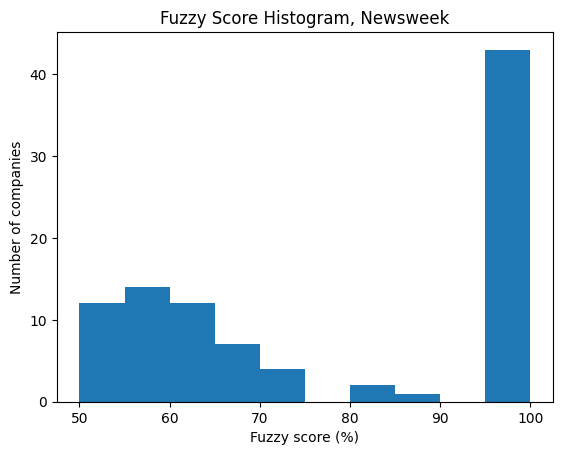

In [14]:
fuzzy_df_nw['Fuzzy_scores'].hist(grid=False)
plt.xlabel(f"Fuzzy score (%)")
plt.ylabel("Number of companies")
plt.title("Fuzzy Score Histogram, Newsweek")

Text(0.5, 1.0, 'Fuzzy Score Histogram, IBD')

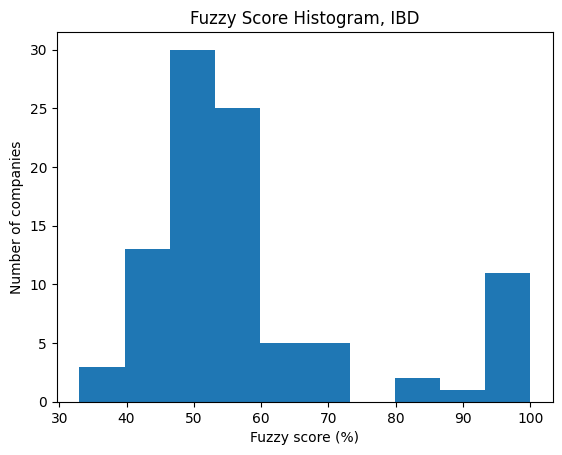

In [15]:
fuzzy_df_ibd['Fuzzy_scores'].hist(grid=False)
plt.xlabel(f"Fuzzy score (%)")
plt.ylabel("Number of companies")
plt.title("Fuzzy Score Histogram, IBD")

- Keep companies where score > N

In [16]:
matched_df_nw = fuzzy_df_nw[fuzzy_df_nw['Fuzzy_scores'] > 86].sort_values('Fuzzy_scores')

print("Number of matched companies:", len(matched_df_nw))
matched_df_nw.head()

Number of matched companies: 43


,CS685_list,Newsweek_list,Fuzzy_scores,nswk_idx
56,mcdonalds,mcdonald's,95,358
1,united parcel service,united parcel service,100,492
59,texas instruments,texas instruments,100,72
61,cisco,cisco systems,100,3
62,mastercard,mastercard,100,9


In [37]:
matched_df_ibd = fuzzy_df_ibd[fuzzy_df_ibd['Fuzzy_scores'] > 90].sort_values('Fuzzy_scores')

print("Number of matched companies:", len(matched_df_ibd))
matched_df_ibd

Number of matched companies: 11


,CS685_list,Newsweek_list,Fuzzy_scores,nswk_idx
18,danaher,danaher,100,72
20,exxon mobil,exxon mobil,100,43
37,chevron,chevron,100,13
57,coca-cola,coca-cola,100,30
59,texas instruments,texas instruments,100,3
62,mastercard,mastercard,100,11
66,ibm,ibm,100,29
71,conocophillips,conocophillips,100,18
77,thermo fisher scientific,thermo fisher scientific,100,32
78,merck,merck,100,8


In [20]:
# nwdf[nwdf['Company'].str.contains('mart')]

---

### Combine scores

In [21]:
df_nw = matched_df_nw.join(nwdf, how='inner', on='nswk_idx').join(odf, how='inner')

In [22]:
df_ibd = matched_df_ibd.join(ibddf, how='inner', on='nswk_idx').join(odf, how='inner')

- Normalize scores

In [23]:
df1 = df_nw.copy()
df2 = df_ibd.copy()

In [24]:
def normalize(series):
    # norm = lambda x: (x - series.mean()) / series.std()
    norm = lambda x: (x - series.min()) / (series.max() - series.min()) * 100
    return series.apply(norm)

In [25]:
# relevant score columns + normalized column names
r_scores_nw = [('Score Overall', 'NWK_score_total'), ('Score Environmental Concerns', 'NWK_score_ESG'), ('score', 'CS_score_total')]
r_scores_ibd = [('ESG Score', 'IBD_score_total'), ('score', 'CS_score_total')]

In [26]:
for s, n in r_scores_nw:
    df1[n] = normalize(df1[s])

In [27]:
for s, n in r_scores_ibd:
    df2[n] = normalize(df2[s])

In [28]:
df1 = df1.sort_values(by=['NWK_score_total', 'CS_score_total']).reset_index(drop=True)
df2 = df2.sort_values(by=['IBD_score_total', 'CS_score_total']).reset_index(drop=True)

In [29]:
df1.head()

,CS685_list,Newsweek_list,Fuzzy_scores,nswk_idx,Rank,Company,HQ City,HQ State,Industry,Rank in Industry,...,Unnamed: 0,score,total_scope3,total_esg,saturation,norm_score,Company name,NWK_score_total,NWK_score_ESG,CS_score_total
0,union pacific,union pacific,100,570,569,Union Pacific,Omaha,Nebraska,Transport & Logistics,19,...,NYSE_UNP_2022_parsed.txt,40.12,40,892,0.200000,5.061685,Union Pacific,0.000000,44.498886,10.240150
1,conocophillips,conocophillips,100,530,529,ConocoPhillips,Houston,Texas,Energy & Utilities,51,...,NYSE_COP_2022_parsed.txt,180.16,272,6072,0.161765,22.835965,ConocoPhillips,5.329027,47.616927,46.636865
2,united parcel service,united parcel service,100,492,492,United Parcel Service,Atlanta,Georgia,Transport & Logistics,13,...,NYSE_UPS_2022_parsed.txt,0.72,0,40,0.100000,0.060923,United Parcel Service,9.325797,0.000000,0.000000
3,honeywell,honeywell international,100,490,490,Honeywell International,Charlotte,North Carolina,Capital Goods,57,...,NYSE_HON_2022_parsed.txt,94.12,72,1800,0.277778,11.915520,Honeywell,9.446912,45.345212,24.274873
4,general electric,portland general electric,100,469,469,Portland General Electric,Portland,Oregon,Energy & Utilities,41,...,NYSE_GE_2022_parsed.txt,280.96,228,4816,0.403509,35.629791,General Electric,11.909568,18.552339,72.835014


In [30]:
df2.head()

,CS685_list,Newsweek_list,Fuzzy_scores,nswk_idx,Rank,Company,Symbol,Industry,ESG Score,Comp Rtg,...,Div Yld,Unnamed: 0,score,total_scope3,total_esg,saturation,norm_score,Company name,IBD_score_total,CS_score_total
0,danaher,danaher,100,72,73,Danaher,DHR,Medical-Diversified,63.54,87,...,0.4,NYSE_DHR_2022_parsed.txt,51.80,44,1068,0.363636,6.544144,Danaher,0.000000,0.000000
1,exxon mobil,exxon mobil,100,43,44,Exxon Mobil,XOM,Oil & Gas-Integrated,66.01,97,...,3.7,ExxonMobil Sustainability Report_parsed.txt,58.44,20,1752,0.000000,7.386912,Exxon Mobil,27.172717,2.839548
2,thermo fisher scientific,thermo fisher scientific,100,32,33,Thermo Fisher Scientific,TMO,Medical-Research Equipment/Services,67.15,85,...,0.2,2022 Corporate Social Responsibility Report_pa...,213.52,236,1976,0.440678,27.070112,Thermo Fisher Scientific,39.713971,69.158399
3,coca-cola,coca-cola,100,30,31,Coca-Cola,KO,Beverages-Non-Alcoholic,67.29,89,...,2.9,The Coca-Cola Company 2022 Business & Sustaina...,141.12,268,2584,0.134328,17.880896,Coca-Cola,41.254125,38.197058
4,ibm,ibm,100,29,30,IBM,IBM,Computer-Technology Services,67.38,81,...,5.1,IBM 2022 ESG Report_parsed.txt,156.92,152,1200,0.500000,19.886277,IBM,42.244224,44.953815


---

### Analysis

,NWK_score_total,CS_score_total
NWK_score_total,1.000000,0.385409
CS_score_total,0.385409,1.000000


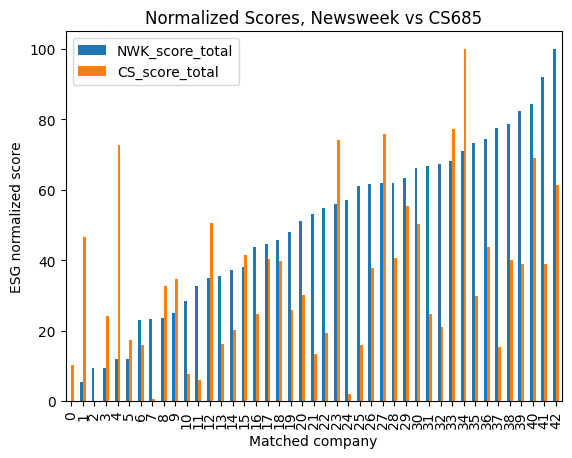

In [46]:
df1[['NWK_score_total', 'CS_score_total']].plot(kind='bar', grid=False)
plt.xlabel(f"Matched company")
plt.ylabel("ESG normalized score")
plt.title("Normalized Scores, Newsweek vs CS685")

corr_mat_nw = df1[['NWK_score_total', 'CS_score_total']].corr()
corr_mat_nw

,NWK_score_ESG,CS_score_total
NWK_score_ESG,1.000000,0.256835
CS_score_total,0.256835,1.000000


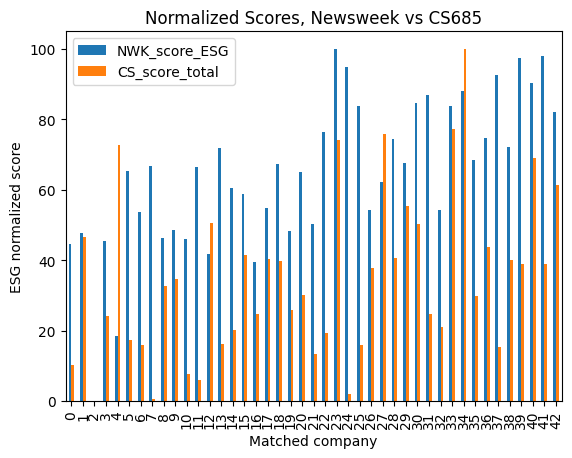

In [47]:
df1[['NWK_score_ESG', 'CS_score_total']].plot(kind='bar', grid=False)
plt.xlabel(f"Matched company")
plt.ylabel("ESG normalized score")
plt.title("Normalized Scores, Newsweek vs CS685")

corr_mat_nw2 = df1[['NWK_score_ESG', 'CS_score_total']].corr()
corr_mat_nw2

,IBD_score_total,CS_score_total
IBD_score_total,1.000000,0.631844
CS_score_total,0.631844,1.000000


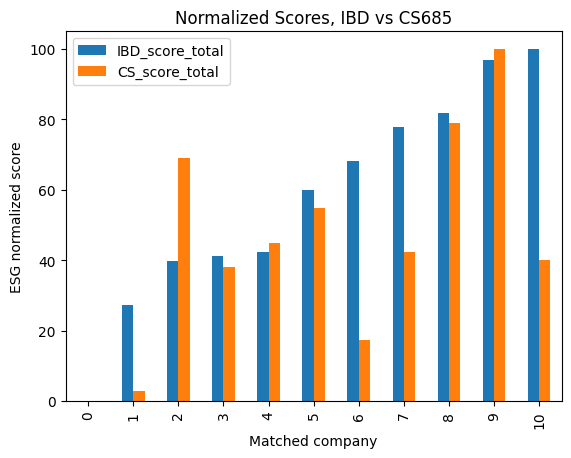

In [48]:
df2[['IBD_score_total', 'CS_score_total']].plot(kind='bar', grid=False)
plt.xlabel(f"Matched company")
plt.ylabel("ESG normalized score")
plt.title("Normalized Scores, IBD vs CS685")

corr_mat_ibd = df2[['IBD_score_total', 'CS_score_total']].corr()
corr_mat_ibd

- Look at Newsweek vs IBD

In [ ]:
fuzzy_df_test = pd.DataFrame(
    fuzzy_matcher(clean_redundant_tokens(ibddf['Company']), clean_redundant_tokens(nwdf['Company']))
)

In [53]:
fuzzy_df_test.columns = ['IBD_list', 'Newsweek_list', 'Fuzzy_scores', 'nswk_idx']

Text(0.5, 1.0, 'Fuzzy Score Histogram, Newsweek vs IBD')

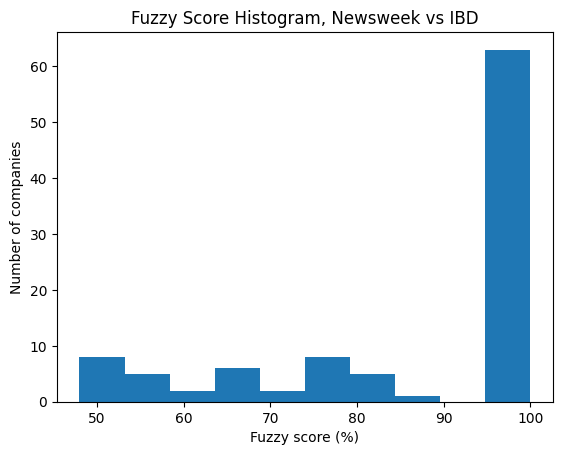

In [55]:
fuzzy_df_test['Fuzzy_scores'].hist(grid=False)
plt.xlabel(f"Fuzzy score (%)")
plt.ylabel("Number of companies")
plt.title("Fuzzy Score Histogram, Newsweek vs IBD")

In [81]:
matched_nwibd = fuzzy_df_test[fuzzy_df_test['Fuzzy_scores'] > 90].sort_values('Fuzzy_scores')

df_nwib = matched_nwibd.join(nwdf, how='inner', on='nswk_idx').join(ibddf[['ESG Score']], how='inner')

In [82]:
df_nwib.columns

Index(['IBD_list', 'Newsweek_list', 'Fuzzy_scores', 'nswk_idx', 'Rank',
       'Company', 'HQ City', 'HQ State', 'Industry', 'Rank in Industry',
       'Score Overall', 'Score Environmental Concerns',
       'Score Social Concerns', 'Score Corporate Governance Concerns',
       'ESG Score'],
      dtype='object')

In [83]:
for s, n in [('Score Overall', 'NWK_score_total'), ('ESG Score', 'IBD_score_total')]:
    df_nwib[n] = normalize(df_nwib[s])

In [84]:
df_nwib = df_nwib.sort_values(by=['NWK_score_total', 'IBD_score_total']).reset_index(drop=True)

63
               Score Overall  ESG Score
Score Overall       1.000000   0.098929
ESG Score           0.098929   1.000000


,Score Environmental Concerns,ESG Score
Score Environmental Concerns,1.000000,0.145552
ESG Score,0.145552,1.000000


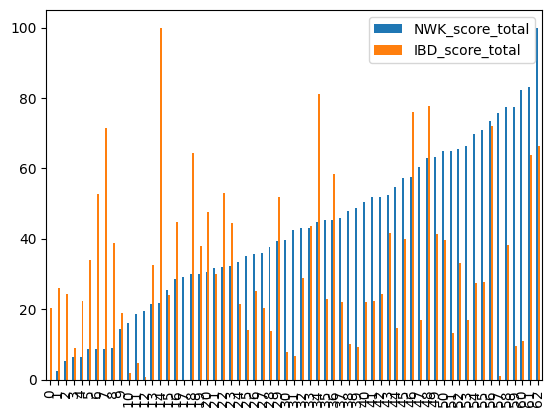

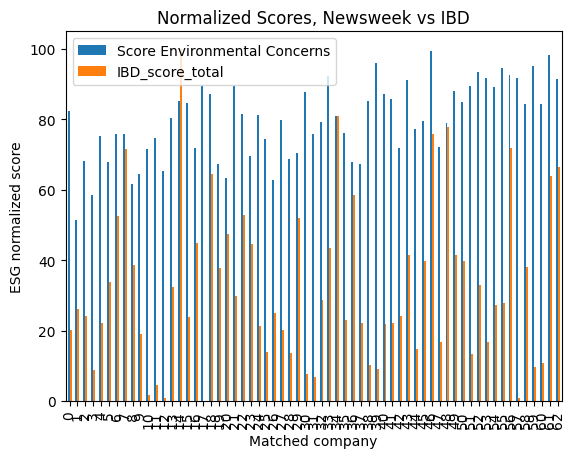

In [89]:
print(len(df_nwib))

df_nwib[['NWK_score_total', 'IBD_score_total']].plot(kind='bar', grid=False)
df_nwib[['Score Environmental Concerns', 'IBD_score_total']].plot(kind='bar', grid=False)
plt.xlabel(f"Matched company")
plt.ylabel("ESG normalized score")
plt.title("Normalized Scores, Newsweek vs IBD")

corr_mat_nwibd = df_nwib[['Score Overall', 'ESG Score']].corr()
corr_mat_nwibd2 = df_nwib[['Score Environmental Concerns', 'ESG Score']].corr()

print(corr_mat_nwibd)
corr_mat_nwibd2

<Axes: >

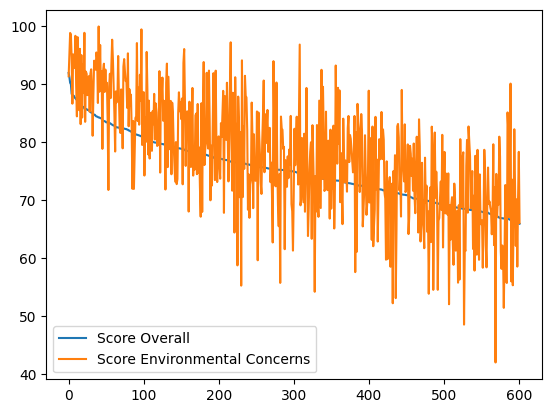

In [34]:
df = nwdf[['Company', 'Score Overall', 'Score Environmental Concerns']]
df.plot()

In [35]:
# variables
f1 = 5

In [92]:
"Validating Results: Comparing against Public Datasets"

writeup = """
In this section, we analyze the correlation between the company scores generated by our results and the results of two externally ranked public datasets. 
The idea is to gain further insights into our method, as a high correlation could provide strong external validation to our method.
Given a less than convincing conclusion, we then explore reasons why our model might differ from the public scores.

For this exercise, we found and scraped two datasets; one from Newsweek's latest annual list of "America's Most Responsible Companies", which includes ESG scores for 600 of the largest corporations in the United States 
and can be found here: https://www.newsweek.com/rankings/americas-most-responsible-companies-2024; and the other from Investor Business Daily's (IBD) annual list of "100 Best ESG Companies For 2022", which 
can be found here: https://www.investors.com/news/esg-companies-list-top-100-esg-stocks-2022/.    

Next, we combined the Newsweek and IBD datasets with our own, which required some finesse since company names do not perfectly match. 
To help us, we employed Python's fuzzywuzzy library, matching our company names separately to Newsweek's and IBD's with fuzzy string matching.
We then analyzed either datasets' results for unmatched companies, making manual changes where the need was apparent (e.g., changing UPS on our side to United Parcel Service).

Using Figure {f1} and {f2} as a barometer, which shows the histogram of fuzzy string matches between our dataset and Newsweek's and IBD's, respectively, we set a miniumum match rate of 87% and 91%.
With this, we were able to match {nw_matched} companies from our list to Newsweek and {ibd_matched} companies to IBD.
Interestingly, some notable companies were not included in the public datasets, including such bellweathers as Amazon, Walmart, Tesla, Pepsi, and Nike in Newsweek for example.

With the datasets now joined, we then normalized the total scores from our method, Newsweek's, and IBD's lists.
Finally, we mapped the Pearson correlation and plotted the results against Newsweek in Figure {f3} and IBD in Figure {f4}.


< Figures >


With a correlation of {corr_nw:.3f} with Newsweek's total score, just {corr_nw2:.3f} with Newsweek's ESG score, and {corr_ibd:.3f} with IBD's ESG score, the reults are effectively meaningless. 
The main questions these results should raise are why do we differ so much from the public datasets, and does this mean our model is useless?  

We answer the second question by exploring the first, and while there is little observed correlation between our model and the public datasets, we conclude that our model is nonetheless informative.  
Specifically, we found three general areas that could easily cause differences between our model's company scores and the public scores.  

- Different scopes: We specifically looked for Scope3 emissions data with our model, whereas the public datasets were more broad, looking at ESG as a whole. And when comparing Newsweek's total score to its "Environmental Concerns" score (i.e., Scope1-3), we observed large differences within the same dataset.
- Different methodology: It's worth noting that the public datasets were not easy to come by, as nearly all are proprietary. Because of this, we were not successful in finding the methodology behind the public score. However, considering for example that our model penalizes on report size (longer reports get more 'points'), and we assign weights to 'generic', 'specific', or 'vauge' statements (subjective summaries), we think it's fair to assume that different methodologies are casuing big differenes between our scores and the public scores.
- Benchmarks differ between each other: We also compared the correlation between Newsweek and IBD, observing meager 9% (using Newsweek's total score) and 14% (on Newsweek's ESG score). The differences between the benchmarks are likely driven by our last point on methodology, and it suggests that low correlations do not mean one model works better than the other.  

""".format(
    f1=f1, f2=f1+1, f3=f1+2, f4=f1+3,
    nw_matched=len(matched_df_nw),
    ibd_matched=len(matched_df_ibd),
    corr_nw=corr_mat_nw.iloc[-1,0],
    corr_nw2=corr_mat_nw2.iloc[-1,0],
    corr_ibd=corr_mat_nw.iloc[-1,0],
)


In [94]:
with open('writeup.txt', 'w') as f:
    f.write(writeup)